#### Load Python Modules

In [1]:
from scipy.sparse import spdiags
import matplotlib.pyplot as plt
import fusion_utils as utils
from tqdm import tqdm 
import numpy as np
import h5py

# Try to Import C-libraries, default to python equivalent instead. 
try: import ctvlib; cRegFlag = True
except: cRegFlag = False

#### Load Chemical Maps 

In [12]:
fname = 'CoSX_maps.h5'; mapNum = 'map7/'

# Parse Chemical Maps
elementList = ['Co', 'O', 'S']

# Load Raw Data and Reshape
file = h5py.File(fname, 'r')

print('Available EDX Maps: ', list(file))

xx = np.array([],dtype=np.float32)
for ee in elementList:

	# Read Chemical Map for Element "ee"
	edsMap = file[mapNum+ee][:,:]

	# Set Noise Floor to Zero and Normalize Chemical Maps
	edsMap -= np.min(edsMap); edsMap /= np.max(edsMap)

	# Concatenate Chemical Map to Variable of Interest
	xx = np.concatenate([xx,edsMap.flatten()])

# Make Copy of Raw Measurements for Poisson Maximum Likelihood Term 
xx0 = xx.copy()

Available EDX Maps:  ['map4', 'map5', 'map6', 'map7', 'map8', 'map9']


#### Parse Meta Data, Prepare Reconstruction and Display Raw Chemical Maps

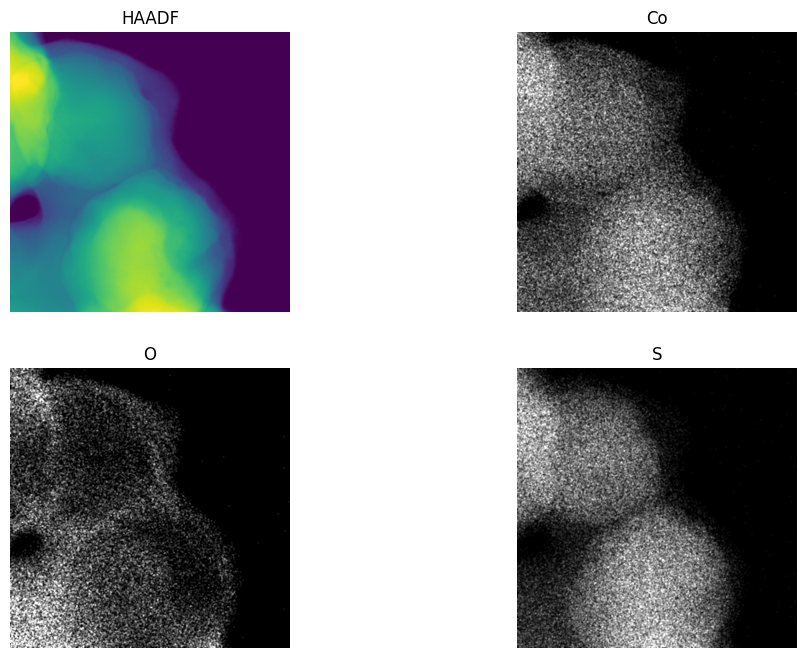

In [13]:
# Image Dimensions
(nx, ny) = edsMap.shape; nPix = nx * ny
nz = len(elementList); lambdaHAADF = 1/nz

# C++ TV Min Regularizers
if cRegFlag: reg = ctvlib.ctvlib(nx, ny)
else:        reg = utils.tvlib(nx,ny)

# HAADF Signal (Measurements)
b = file[mapNum+'HAADF'][:].flatten()

# Data Subtraction and Normalization 
b -= np.min(b); b /= np.max(b)

# Create Summation Matrix
A = utils.create_measurement_matrix(nx,ny,nz)

# Show Raw Data
utils.plot_elemental_images(xx, b, elementList, nx, ny, 2,2)

#### Perform Multi-Modal Data Fusion

100%|██████████| 50/50 [00:12<00:00,  4.10it/s]


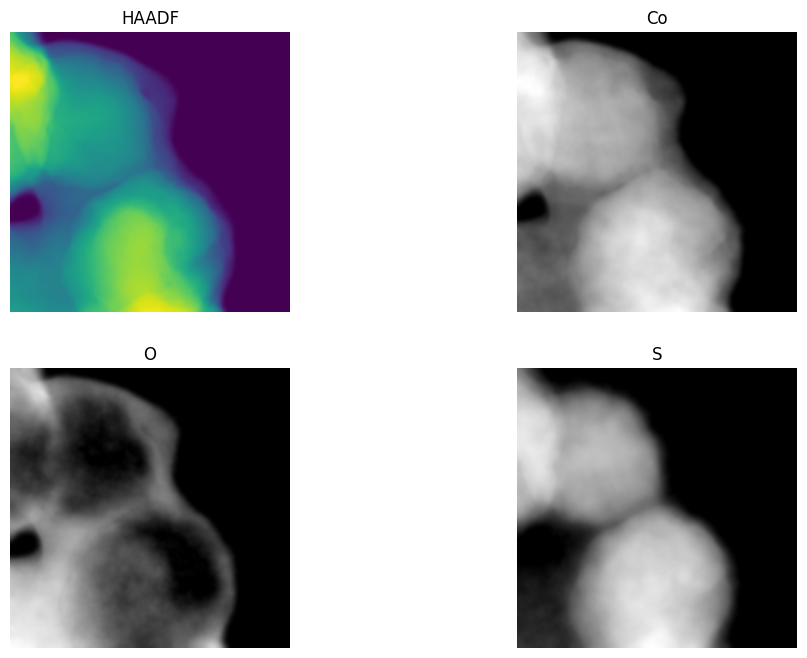

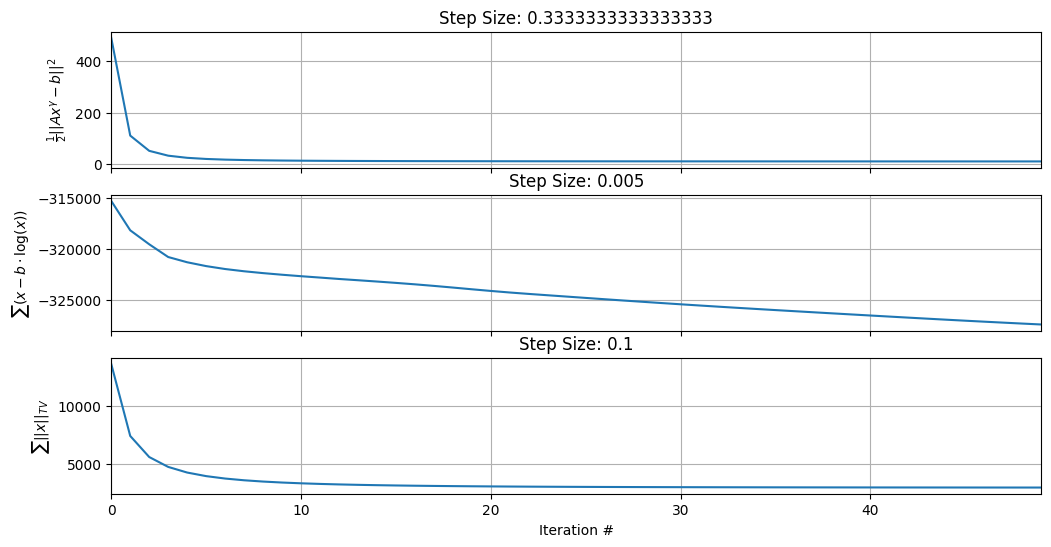

In [14]:
# Convergence Parameters
gamma = 1.6; lambdaEDS = 0.005; nIter = 50; bkg = 1e-1

# TV Min Parameters
regularize = True; ng = 15; lambdaTV = 0.1; 

###############################################################################################################

# Auxiliary Functions
lsqFun = lambda inData : 0.5 * np.linalg.norm(A.dot(inData**gamma) - b) **2
poissonFun = lambda inData : np.sum(xx0 * np.log(inData + 1e-8) - inData)

# Main Loop
costHAADF = np.zeros(nIter,dtype=np.float32); costEDS = np.zeros(nIter, dtype=np.float32); costTV = np.zeros(nIter, dtype=np.float32);
for kk in tqdm(range(nIter)):

	# HAADF Update
	xx -=  gamma * spdiags(xx**(gamma - 1), [0], nz*nx*ny, nz*nx*ny) * lambdaHAADF * A.transpose() * (A.dot(xx**gamma) - b) + lambdaEDS * (1 - xx0 / (xx + bkg))
	xx[xx<0] = 0

	# Regularization 
	if regularize:
		for zz in range(nz):
			if cRegFlag: xx[zz*nPix:(zz+1)*nPix] = reg.fgp_tv( xx[zz*nPix:(zz+1)*nPix], lambdaTV, ng)	
			else :  	 xx[zz*nPix:(zz+1)*nPix] = reg.fgp_tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny), lambdaTV, ng).flatten()
			
	# Measure Cost Function
	costHAADF[kk] = lsqFun(xx); costEDS[kk] = poissonFun(xx)

	# Measure Isotropic TV 
	if regularize:
		for zz in range(nz):
			costTV[kk] += reg.tv( xx[zz*nPix:(zz+1)*nPix].reshape(nx,ny) )

# Show Reconstructed Signal
utils.plot_elemental_images(xx,A.dot(xx**gamma),elementList,nx,ny,2,2)

# Display Cost Functions and Descent Parameters
utils.plot_convergence(costHAADF, lambdaHAADF, costEDS, lambdaEDS, costTV, lambdaTV)

##### Save Results (Optional)

In [ ]:
# Save Images
utils.save_images(xx, A.dot(xx**gamma), elementList, nx, ny)

# Save Cost Functions (Experiment)
file = h5py.File('results/CoSX_convergence.h5', 'w')
file.create_dataset('costHAADF', data=costHAADF); file['lambdaHAADF'] = lambdaHAADF
file.create_dataset('costEDS', data=costEDS); file['lambdaEDS'] = lambdaEDS
file.create_dataset('costTV', data=costTV); file['lambdaTV'] = lambdaTV
file['gamma'] = gamma; file.close()